In [14]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

pd.options.mode.chained_assignment = None  # default='warn'

In [15]:
df_all = pd.read_csv('dataset/recovery-news-data.csv')

In [16]:
df_all['reliability'][df_all.reliability == 1] = 'true'
df_all['reliability'][df_all.reliability == 0] = 'fake'

In [17]:
print("Wiersze:", df_all.shape[0])
print("Kolumny:", df_all.shape[1])

Wiersze: 2029
Kolumny: 12


In [18]:
df_all.sample(10)

,Unnamed: 0,news_id,url,publisher,publish_date,author,title,image,body_text,political_bias,country,reliability
1494,1494,1494,https://www.politico.com/news/magazine/2020/05...,Politico,2020-05-19,['Michele A. Berdy'],How Russia’s Coronavirus Crisis Got So Bad,https://static.politico.com/a5/ad/5d422de34141...,"Despite the official assurances, by mid-March ...",Center,USA,true
1027,1027,1027,https://www.businessinsider.com/how-influencer...,Business Insider,2020-05-15,"['Amanda Perelli', 'Dan Whateley']",YouTube and Instagram influencers share their ...,https://i.insider.com/5ebb01cb48d92c194d113678...,The ad business has been hurting for influence...,Left-center,USA,true
1671,1671,1671,https://www.politico.com/news/2020/05/21/how-c...,Politico,2020-05-21,['Miriam Webber'],How coronavirus is changing access to abortion,https://static.politico.com/a0/ec/7bbf1b4542e7...,"Since the outbreak, 94 percent of IPPF EN memb...",Center,USA,true
48,48,48,https://www.usatoday.com/in-depth/graphics/202...,USA Today,2020-03-10,"['Karina Zaiets', 'Mitchell Thorson', 'Shawn J...",US coronavirus map: Tracking the outbreak,https://www.gannett-cdn.com/presto/2020/04/02/...,The number of patients diagnosed with COVID-19...,Center,USA,true
1548,1548,1548,https://www.worldhealth.net/news/what-private-...,WorldHealth.Net,2020-05-20,[],What Private Practices Need to Know About the ...,https://www.worldhealth.net/media/original_ima...,\n\nThere is a dire need for financial support...,NaN,USA,fake
1822,1822,1822,https://clashdaily.com/2020/05/shocking-cuomos...,Clash Daily,2020-05-22,['K. Walker'],"SHOCKING: Cuomo’s Policy Sent More Than 4,300 ...",https://clashdaily.com/wp-content/uploads/2020...,Governor Andrew Cuomo who said “the buck stops...,Extreme right,NaN,fake
1112,1112,1112,https://www.businessinsider.com/power-line-how...,Business Insider,2020-05-15,['Benji Jones'],Power Line: How coronavirus will permanently c...,https://i.insider.com/5ebebcddaee6a87450093737...,"Welcome to Power Line, a weekly energy newslet...",Left-center,USA,true
1270,1270,1270,https://www.americanthinker.com/articles/2020/...,American Thinker,2020-05-17,['Dan Truitt'],Federalism’s Latest Champion,https://www.americanthinker.com/images/bucket/...,"The further left you go in your politics, the ...",Extreme right,USA,fake
132,132,132,https://chicago.suntimes.com/coronavirus/2020/...,Chicago Sun-Times,2020-03-23,['Satchel Price'],How to apply for unemployment benefits if you ...,https://cdn.vox-cdn.com/thumbor/1m47pSP6hWHQzN...,With applications by state residents for unemp...,Left-center,USA,true
1734,1734,1734,https://www.infowars.com/the-worst-unemploymen...,InfoWars,2020-05-22,['Michael Snyder'],The Worst Unemployment Spike In U.S. History –...,https://assets.infowars.com/2020/05/GettyImage...,Even though most U.S. states have begun the pr...,Right,USA,fake


Należy sprawadzić, czy w kolumnie "content" znajdują się jakieś puste wartości lub duplikaty.

In [19]:
nan = df_all['body_text'].isnull().sum(axis = 0)
print("Liczba NaN w kolumnie 'content':",(nan))

unique = df_all['body_text'].nunique()
print("Liczba duplikatów:",(len(df_all) - unique))
df_all = df_all.drop_duplicates(subset='body_text', keep="last")

#liczba duplikatów
print("Liczba duplikatów po operacji:",(len(df_all['body_text']) - df_all['body_text'].nunique()))
print("Liczba wierszy po operacji:", len(df_all))

Liczba NaN w kolumnie 'content': 0
Liczba duplikatów: 119
Liczba duplikatów po operacji: 0
Liczba wierszy po operacji: 1910


In [20]:
# Wybieram tylko dane pochodzące z USA, ale można by jeszcze Kanadę i UK wziąć pod uwagę
df_all = df_all[df_all['country']=='USA']

In [21]:
print("Liczba wierszy po operacji:", len(df_all))
print("Kolumny:", df_all.shape[1])

Liczba wierszy po operacji: 1589
Kolumny: 12


W kolumnie "publisher" można znaleźć nazwy gazet lub portali, które opublikowały zebrane w zbiorze newsy.

In [22]:
df_all['publisher'][df_all.reliability == 'true'].value_counts()

Chicago Sun-Times              321
Business Insider               158
The Verge                      139
USA Today                      107
National Public Radio (NPR)     92
The New York Times              67
CBS News                        67
CNBC                            46
Yahoo! News                     36
The Washington Post             33
The Detroit News                28
Slate                           24
Politico                        23
Los Angeles Daily News          20
ABC News                        18
The Mercury News                17
The Atlantic                    13
The New Yorker                  12
PBS NewsHour                    10
FiveThirtyEight                  2
Washington Monthly               1
Name: publisher, dtype: int64

In [23]:
df_all['publisher'][df_all.reliability == 'fake'].value_counts()

WorldHealth.Net         75
American Thinker        32
Heartland Institute     30
Drudge Report           26
FrontPage Magazine      25
Natural News            23
Health Impact News      19
InfoWars                16
DC Dirty Laundry        15
Humans Are Free         14
The Gateway Pundit      13
GreenMedInfo            11
True Pundit             11
Geller Report News      10
Health Nut News         10
Big League Politics      8
Collective Evolution     5
Bipartisan Report        4
The Mind Unleashed       4
News Punch               3
Waking Times             1
Name: publisher, dtype: int64

true    1234
fake     355
Name: reliability, dtype: int64


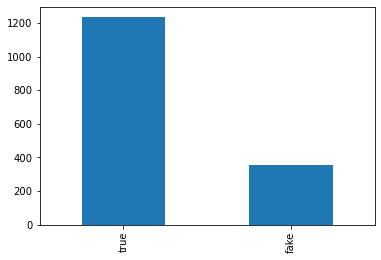

In [24]:
df_all['reliability'].value_counts(normalize=False).plot(kind='bar');
print(df_all['reliability'].value_counts())

W zbiorze reCOVery znajduje się kolumna 'political_bias', która informuje o nacechowaniu politycznym danego newsa. Sprawdźmy ile newsów znalazło się w danej kategorii.

In [25]:
df_all['political_bias'].value_counts()

Left-center      849
Center           234
Left             103
Extreme right    101
Right             82
Right-center      48
Extreme left       4
Name: political_bias, dtype: int64

In [26]:
# Usunięcie kolumn, które nie będą już potrzebne w dalszej analizie
df_all['text'] = df_all['body_text']
df_all['target'] = df_all['reliability']
df = df_all[['target', 'text']]

# Podstawowa normalizacja - zmiana tekstu na małe litery
df['text_norm'] = df['text'].str.lower()

df.head(5)

,target,text,text_norm
0,true,\nA novel respiratory virus that originated in...,\na novel respiratory virus that originated in...
1,true,Chinese Health Officials: More Die From Newly ...,chinese health officials: more die from newly ...
2,true,Public health experts around the globe are scr...,public health experts around the globe are scr...
3,fake,The first two coronavirus cases in Europe have...,the first two coronavirus cases in europe have...
4,true,"A new coronavirus appeared in Wuhan, China, at...","a new coronavirus appeared in wuhan, china, at..."


In [27]:
# Policzmy, ile mamy wszystkich Tokenów w Korpusie
tokens_set = set()
df['text_norm'].str.split(" ").map(tokens_set.update)
print(len(tokens_set))

115393


In [28]:
# Pokażmy 20 najczęściej występujących Tokenów oraz liczbę ich wystąpień w Korpusie
cntr = Counter()
df["text_norm"].str.split(" ").map(cntr.update)
cntr.most_common(n=20)

[('the', 71701),
 ('to', 43515),
 ('and', 35868),
 ('of', 35752),
 ('a', 28780),
 ('in', 26072),
 ('that', 16581),
 ('for', 14575),
 ('is', 13205),
 ('on', 10553),
 ('are', 9556),
 ('with', 9078),
 ('have', 8703),
 ('as', 8267),
 ('be', 7964),
 ('at', 7370),
 ('it', 7043),
 ('from', 6406),
 ('was', 6322),
 ('has', 6091)]

In [29]:
# Możemy zliczyć sumę wystąpień poszczególnych Tokenów w każdym Dokumencie i zapisać to w dodatkowej kolumnie. 
# Dzięki temu powstał uproszczony Bag of Words dla każdego dokumentu.

df["text_norm_counter"] = df["text_norm"].str.split(" ").map(lambda x: dict(Counter(x)) )
df["counter_tokens"] = df["text_norm_counter"].map(lambda x: sum(x.values()) )

In [30]:
df.sample(5)

,target,text,text_norm,text_norm_counter,counter_tokens
1156,true,While many states across the US have begun to ...,while many states across the us have begun to ...,"{'while': 2, 'many': 3, 'states': 3, 'across':...",399
1270,fake,"The further left you go in your politics, the ...","the further left you go in your politics, the ...","{'the': 54, 'further': 2, 'left': 3, 'you': 5,...",904
899,true,NEW YORK — The big budget musical “Frozen” wil...,new york — the big budget musical “frozen” wil...,"{'new': 4, 'york': 2, '—': 1, 'the': 14, 'big'...",352
106,true,As many businesses take a hit amid the rising ...,as many businesses take a hit amid the rising ...,"{'as': 3, 'many': 2, 'businesses': 1, 'take': ...",419
1402,true,Jason Sattler\n\nOpinion columnist\n\nI have n...,jason sattler\n\nopinion columnist\n\ni have n...,"{'jason': 1, 'sattler opinion': 1, 'columnist...",965


In [31]:
# Przyjrzyjmy się bliżej zliczaniu tokenów na przykładzie losowego newsa

rng = np.random.default_rng()
index = rng.integers(low=0, high=1589)

print('id: ', index)
print('--------------------')
print(df.loc[[index], 'text_norm'].values[0])
df.loc[[index], 'text_norm_counter'].values[0]

id:  1189
--------------------
staff

usa today network pressroom

usa today announced today it is launching a special daily section focused on covid-19 news and information. the new section, nation’s health, will be a standing section inside the usa today print and e-edition newspapers and will appear on digital platforms as well. the special section will also be emailed to subscribers of gannett’s local news publications. gannett has journalists reporting from all 50 states on the scope of and reaction to the crisis. this section aggregates the best of that content, with updates on testing, confirmed cases, mitigation, closures, cancellations and the new normal for america.

the nation is turning to usa today for clear, up to date information on the outbreak. in the past 30 days, usa today has had more than 100 million views of its coronavirus stories, videos, graphics and photo galleries.

in addition, usa today has:

launched a coronavirus newsletter, its readership growing to more

{'staff\n\nusa': 1,
 'today': 7,
 'network': 1,
 'pressroom\n\nusa': 1,
 'announced': 1,
 'it': 2,
 'is': 3,
 'launching': 2,
 'a': 3,
 'special': 2,
 'daily': 1,
 'section': 5,
 'focused': 2,
 'on': 6,
 'covid-19': 1,
 'news': 3,
 'and': 12,
 'information.': 1,
 'the': 15,
 'new': 2,
 'section,': 1,
 'nation’s': 2,
 'health,': 1,
 'will': 4,
 'be': 4,
 'standing': 1,
 'inside': 1,
 'usa': 5,
 'print': 1,
 'e-edition': 1,
 'newspapers': 1,
 'appear': 1,
 'digital': 1,
 'platforms': 1,
 'as': 1,
 'well.': 1,
 'also': 1,
 'emailed': 1,
 'to': 9,
 'subscribers': 2,
 'of': 7,
 'gannett’s': 3,
 'local': 2,
 'publications.': 1,
 'gannett': 1,
 'has': 3,
 'journalists': 1,
 'reporting': 1,
 'from': 1,
 'all': 2,
 '50': 1,
 'states': 1,
 'scope': 1,
 'reaction': 1,
 'crisis.': 1,
 'this': 2,
 'aggregates': 1,
 'best': 1,
 'that': 2,
 'content,': 1,
 'with': 2,
 'updates': 1,
 'testing,': 1,
 'confirmed': 1,
 'cases,': 1,
 'mitigation,': 1,
 'closures,': 1,
 'cancellations': 1,
 'normal': 1,
 '

In [32]:
df.to_csv('recovery_dataset.csv', encoding='utf-8', index=False)
df.to_excel("recovery.xlsx")